In [1]:
import pandas as pd
import numpy as np
import random
import math
import timeit
import itertools
import warnings
import pickle
import feather
import gc
import sys
import os
import matplotlib.pyplot as plt
from os.path import join, isfile
from collections import Counter
from xgboost import XGBClassifier
from fcmeans import FCM
import scipy.stats as stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, classification_report, mutual_info_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier,BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.2f}".format(x)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
mainPath = "../../data"
beacons = join(mainPath, "beacon")
testSets = join("", "test_sets")
models = join(mainPath, "models")
ceuPath = join(beacons, "CEU")
opensnpPath = join(beacons, "OpenSNP")
inferencePath = join("", "inference")

#### STEP 1: Load Beacon, MAF, Reference and other cached variables

In [3]:
features = [ 'EyeColor','HairType','HairColor','TanAbility','Asthma','LactoseIntolerance',#'BloodType',
             'EarWax','Freckling','TongueRoller','RingFinger','Intolerance','WidowPeak','ADHD','Acrophobia',
             'FingerHair','Myopia','IrritableBowel','IndexLongerBig','Photoptarmis','Migraine','RhProtein']
with open(join(opensnpPath, "OpenSNP_Phenotype.pickle"), 'rb') as handle:
    pheno = pickle.load(handle)
pheno = pheno[features]
pheno[pheno=="Auburn"] = "Blonde"
pheno[pheno=="Black"] = "Brown"

with open(join(opensnpPath, "MAF.pickle"), 'rb') as handle:
    maf = pickle.load(handle)

with open(join(opensnpPath, "Reference.pickle"), 'rb') as handle:
    reference = pickle.load(handle)
reference = reference.values

with open(join(opensnpPath, "Beacon.pickle"), 'rb') as handle:
    beacon = pickle.load(handle)

with open(join(opensnpPath, "BinaryBeacon.pickle"), 'rb') as handle:
    binary = pickle.load(handle)
    
with open(join(opensnpPath, "TernaryBeacon.pickle"), 'rb') as handle:
    ternary = pickle.load(handle)

#### Constrainted Indices

In [4]:
pheno5People = pheno.iloc[np.where(np.sum(pheno != "-", axis = 1) >=10)[0]].index
pheno5People = pheno5People.map(str)
pheno5People = np.where(beacon.columns.isin(pheno5People))[0]

pheno1People = pheno.iloc[np.where(np.sum(pheno != "-", axis = 1) >= 1)[0]].index
pheno1People = pheno1People.map(str)
pheno1People = np.where(beacon.columns.isin(pheno1People))[0]

phenoAllPeople = np.arange(beacon.shape[1])

Counter({1: 668, 0: 536, 2: 116})
[[517.16 18.28 0.50 -2.28]
 [-343.34 -188.36 2.14 1.20]
 [-412.45 1000.26 -14.64 3.62]]
(536,) (668,) (116,)
(94,) (60,) (5,)


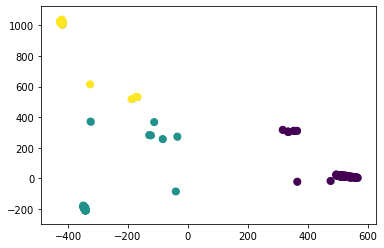

In [45]:
pca = PCA(n_components=4)
tr1 = pca.fit_transform(ternary[:, pheno1People].T)
plt.scatter(tr1[:, 0], tr1[:, 1], alpha=0.4)

kmeans = KMeans(3)
y_kmeans = kmeans.fit_predict(tr1)
plt.scatter(tr1[:, 0], tr1[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
print(Counter(y_kmeans))
print(centers)

# In[7]:


# Get indices of homogeneous groups
g1 = pheno1People[np.where(y_kmeans == 0)[0]]
g2 = pheno1People[np.where(y_kmeans == 1)[0]]
g3 = pheno1People[np.where(y_kmeans == 2)[0]]
print(g1.shape, g2.shape, g3.shape)

g1a = np.intersect1d(g1, pheno5People)
g2a = np.intersect1d(g2, pheno5People)
g3a = np.intersect1d(g3, pheno5People)
print(g1a.shape, g2a.shape, g3a.shape)

#### STEP 1.2: Function Definitions

In [5]:
# Beacon operations
def queryBeacon(beacon_people):
    return binary[:, beacon_people].any(axis=1)

def getMutationAt(index):
    temp = maf.iloc[index]
    if temp["minor_freq"] == temp["maf"]:
        return temp["minor"] + temp["major"] 
    else:
        return temp["major"] + temp["minor"] 

def div(n, d):
    return n / d if d else 0

def rpaCalculate(tp,fp,tn,fn):
    recall = div(tp,(tp+fn)) 
    precision = div(tp,(tp+fp))
    accuracy = div((tp+tn),(tp+fp+tn+fn))
    return recall, precision, accuracy

def getTrainingData(phenotype, pos, test_people):
    # Find indices of people who has the specified feature
    feature_label = pheno[pheno[phenotype] != "-"][phenotype]
    existing = beacon.columns.isin(feature_label.index.values)
    existing[test_people] = False 
    
    # Get training data
    X = binary[pos][:, existing].T
    Y = feature_label[beacon.columns[existing]].values
    return X, Y

# Performance method
def performance(person, reconstruction, eval_pos, reference):
    ind = np.logical_and(person[eval_pos] != np.squeeze(reference)[eval_pos], person[eval_pos] != "NN")
    tp = np.sum(reconstruction[eval_pos][ind] != np.squeeze(reference)[eval_pos][ind])
    fn = np.sum(ind) - tp
    fp = np.sum(reconstruction[eval_pos][~ind] != np.squeeze(reference)[eval_pos][~ind])
    tn = np.sum(~ind) - fp

    return tp, fp, tn, fn

def performance_f(test_people, reconstructed, add_count, cluster_count, eval_pos):
    total_values = np.zeros((4))
    best_matches = []
    # For all people in victim set
    for i in range(add_count):
        all_combinations = np.zeros((4, cluster_count))
        rpa = np.zeros((3, cluster_count))
        # For each cluster obtained
        for j in range(cluster_count):
            all_combinations[:, j] = performance(test_people[i], reconstructed[j], eval_pos, reference)
            rpa[:, j] = rpaCalculate(*all_combinations[:, j])
        ind = np.argmax(rpa[0,:]*rpa[1,:])       #Best-match index
        best_matches.append(ind)
        total_values += all_combinations[:, ind] #Add total tp-fp-tn-fn
    recall, precision, accuracy = rpaCalculate(*total_values)
    print("Recall_Micro_Avg    =", round(recall, 2),"\nPrecision_Micro_Avg =", round(precision, 2))
    return (precision,recall,accuracy), total_values, best_matches

#### STEP 2: Choose random people and send query to Beacon to obtain No-Yes answers

In [6]:
def getNoYes(add_count, beacon_size):

    # Take people for added group
    added_people = pheno5People.copy()
    random.shuffle(added_people)
    added_people = added_people[:add_count]
    
    # Take people for beacon
    beacon_people = np.setdiff1d(phenoAllPeople, added_people)
    random.shuffle(beacon_people)
    beacon_people = beacon_people[:beacon_size]

    # Query Beacon initially
    before = queryBeacon(beacon_people)
    # Add people
    updated_beacon = np.concatenate([added_people,beacon_people])
    # Query Beacon again
    after = queryBeacon(updated_beacon)
    # Find No-Yes SNPs' indices
    no_yes_indices = np.where(np.logical_and(before==False, after==True))[0]
    yes_yes_indices = np.where(np.logical_and(before==True, after==True))[0]
    print("Number of No-Yes SNP's : ", len(no_yes_indices))
    
    return yes_yes_indices, no_yes_indices, added_people

In [1]:
print(np.arange(200))

NameError: name 'np' is not defined

In [92]:
def getNoYes2(add_count, beacon_size):

    # Take people for added group
    random.shuffle(g1a)
    random.shuffle(g2a)
    random.shuffle(g3a)
    if add_count >= 5:
        added_people = np.concatenate([g1a[:(2 * add_count // 5)], g2a[:(2 * add_count // 5)], g3a[:(add_count // 5)]])
    elif add_count == 3:
        added_people = np.concatenate([g1a[:(add_count // 3)], g2a[:(add_count // 3)], g3a[:(add_count // 3)]])
    elif add_count == 2:
        added_people = np.concatenate([g1a[:(add_count // 2)], g2a[:(add_count // 2)]])

    # Take people for beacon
    g1_ = np.setdiff1d(g1, g1a)
    random.shuffle(g1_)
    g2_ = np.setdiff1d(g2, g2a)
    random.shuffle(g2_)
    g3_ = np.setdiff1d(g3, g3a)
    random.shuffle(g3_)
    if add_count >= 5:
        curBeacon = np.concatenate([g1_[:(2 * beacon_size // 5)], g2_[:(2 * beacon_size // 5)], g3_[:(beacon_size // 5)]])
    elif add_count == 3:
        curBeacon = np.concatenate([g1_[:(beacon_size // 3)], g2_[:(beacon_size // 3)], g3_[:(beacon_size // 3)]])
    elif add_count == 2:
        curBeacon = np.concatenate([g1_[:(beacon_size // 2)], g2_[:(beacon_size // 2)]])

    # Query Beacon initially
    before = queryBeacon(curBeacon)
    # Add people
    updatedBeacon = np.concatenate([added_people, curBeacon])
    # Query Beacon again
    after = queryBeacon(updatedBeacon)
    # Find No-Yes SNPs' indices
    no_yes_indices = np.where(np.logical_and(before == False, after == True))[0]
    yes_yes_indices = np.where(np.logical_and(before == True, after == True))[0]
    print("Number of No-Yes SNP's : ", len(no_yes_indices))

    return yes_yes_indices, no_yes_indices, added_people, curBeacon

#### STEP 3: Correlation Model

In [7]:
def builtSNPNetwork(no_yes_indices, model_ind, reference):
    model = ternary[no_yes_indices][:, model_ind].astype(float)
    model[model==-1] = np.nan
    x = pairwise_distances(model, metric = "sokalmichener", n_jobs=-1)
    x = 1-np.nan_to_num(x)
    return x

##### Spectral Clustering

In [8]:
def spectralClustering(no_yes_indices, add_count, x, reference, cluster_count=None):
    if not cluster_count:
        cluster_count = add_count
    sc = SpectralClustering(cluster_count, affinity='precomputed', n_init=100, n_jobs=-1)
    sc.fit(np.array(x))
    bins = []
    for i in range(cluster_count):
        temp = []
        for element in np.where(sc.labels_==i)[0]:
            temp.append(no_yes_indices[element])
        #print("Bin " + str(i) + " has " + str(len(temp)) + " SNP's")
        bins.append(temp)
    reconstructed = np.array([reference.T[0] for i in range(cluster_count)])
    for i in range(cluster_count):
        for j in bins[i]:
            reconstructed[i][j] = getMutationAt(j)
    return reconstructed

#### Fuzzy Clustering

In [9]:
def fuzzyClustering(no_yes_indices, add_count, x, reference):
    fcm = FCM(n_clusters=add_count)
    fcm.fit(x)
    soft_clusters = fcm.u 
    bins = [[] for i in range(add_count)]
    for i in range(len(soft_clusters)):
        maxPos = np.argmax(soft_clusters[i])
        if  soft_clusters[i][maxPos] <= 0.5:
            for j in np.where(soft_clusters[i] > (soft_clusters[i][maxPos]*2/3))[0]:
                bins[j].append(no_yes_indices[i])
        else:
            bins[maxPos].append(no_yes_indices[i])
    reconstructed = np.array([reference.T[0] for i in range(cluster_count)])
    for i in range(cluster_count):
        for j in bins[i]:
            reconstructed[i][j] = getMutationAt(j)
    return reconstructed

# E X P E R I M E N T 

In [154]:
add_count = 5
cluster_count = 5
beacon_size = 50
yes_yes_ind, no_yes_ind, added_people, beacon_people     = getNoYes2(add_count, beacon_size)

Number of No-Yes SNP's :  11473


### Using all the people

In [155]:
%%time
model_ind = pheno1People
correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
(precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)

Recall_Micro_Avg    = 0.91 
Precision_Micro_Avg = 0.83
CPU times: user 3min 15s, sys: 8.67 s, total: 3min 24s
Wall time: 26.6 s


### Using other people

In [156]:
%%time
model_ind = np.setdiff1d(pheno1People, added_people)
model_ind = np.setdiff1d(model_ind, beacon_people)

correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
(precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)

Recall_Micro_Avg    = 0.91 
Precision_Micro_Avg = 0.83
CPU times: user 3min 6s, sys: 6.49 s, total: 3min 13s
Wall time: 19.1 s


## Genome Reconstruction

In [ ]:
add_count = 10
cluster_count = 10
beacon_size = 100
yes_yes_ind, no_yes_ind, added_people     = getNoYes(add_count, beacon_size)

In [ ]:
%%time
correlations                              = builtSNPNetwork(no_yes_ind, pheno1People, reference)
reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
(precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)

###### Brute Force Trials

In [ ]:
experiments = [(2, 20, 0.9), (3, 30, 0.8), (5, 50, 0.8), (10, 100, 0.8), (20, 100, 0.65), (30, 100, 0.6), (40, 100, 0.55)]

for e in experiments:
    add_count = e[0]
    cluster_count = add_count
    beacon_size = e[1]
    target = e[2]
    test_sets = []
    for i in range(10):
        precision, recall = 0, 0
        while precision + recall < target * 2:
            yes_yes_ind, no_yes_ind, added_people     = getNoYes(add_count, beacon_size)
            correlations                              = builtSNPNetwork(no_yes_ind, pheno5People, reference)
            reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
            (precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)
        gs = [yes_yes_ind, no_yes_ind, added_people]
        test_sets.append(gs)
    filename = str(e[0]) + "_testset.pkl" 
    with open(join(beacons, filename), 'wb') as f:
        pickle.dump(test_sets, f)

## Phenotype Prediction

In [ ]:
def evaluate_ensemble(models, x_test, y_test, add_count, cluster_count):
    # Predict
    results = []
    for i in models:
        results.append(i[1].predict_proba(x_test))
    labels = [i[0] for i in models]

    top3, top1 = 0, 0
    # For each person
    for i in range(add_count):
        test_person = y_test[labels].iloc[i]
        available_phenotypes = np.where(test_person != "-")[0]

        # For each reconstructed genome
        probs = np.zeros((cluster_count))
        for j in range(cluster_count):
            # For each available phenotype
            for k in available_phenotypes:
                target_label_ind = np.where(models[k][1].classes_ == test_person[k])[0]
                probs[j] += results[k][j][target_label_ind]# * models[k][2]

        # Top k
        matched_ind = np.argsort(probs)[-3:]
        print(probs, "\n", matched_ind, "--", matches[i], "\n")
        if matches[i] in matched_ind:
            top3 += 1
        if matches[i] == matched_ind[-1]:
            top1 += 1
    print("Top-1 Accuracy= ", top1 / add_count, "\tTop-3 Accuracy= ", top3 / add_count)
    return top1 / add_count, top3 / add_count

In [ ]:
Estimators= [100]  # n_estimators
Depths    = [3,4,6,None] # max_depth (None olabilir)
MinSample = [4,8,10,12]  # min_samples_leaf
MaxFeatures = ["auto", 1/2, 1/4]  # min_samples_leaf

#Impurity  = [0]  # min_impurity_decrease
Criterion = ["gini"]                  # criterion
parameters = {"max_depth":Depths,"min_samples_leaf":MinSample,"criterion":Criterion,"n_estimators":Estimators,"max_features":MaxFeatures}
              #"min_impurity_decrease":Impurity,"min_samples_split":MinSplit}

In [ ]:
def train_models(train_snps, test_people):
    models = []
    count = 1
    for feature in features:
        X, Y = getTrainingData(phenotype=feature, pos=train_snps, test_people=test_people)
        print("\n",count, ".", feature, "\tlabels=", np.unique(Y))
        
        # Upsampling
        X, Y = SMOTE().fit_sample(X, Y)
        # Train the model
        rf = RandomForestClassifier(class_weight='balanced_subsample',oob_score=True,n_jobs=-1)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)
        model = GridSearchCV(cv=cv, estimator=rf, scoring='f1_macro', param_grid=parameters,verbose=0,n_jobs=-1)
        result = model.fit(X, Y)

        print("Best: %f using %s" % (result.best_score_, result.best_params_))
        best_model = result.best_estimator_
        best_score = (result.best_score_ + best_model.oob_score_) / 2
        #best_model.fit(X, Y)
        
        if best_score > 1.2 / len(np.unique(Y)):
            count += 1
            print("Train:", round(best_model.score(X, Y), 2), " | Validation:", round(best_score,2))
            models.append((feature, model, best_score))
    return models

#### Single Experiment

In [ ]:
experiments = [(2,20, 0.9),(3,30, 0.8),(5,50, 0.8),(10,100, 0.8),(20,100, 0.65)]

e = experiments[0]
add_count = e[0]
beacon_size = e[1]

with open(join(testSets, str(add_count) + "_testset.pkl"), 'rb') as f:
    test_sets = pickle.load(f)

top1s, top3s = [], []
for i in range(10):
    yes_yes_ind, no_yes_ind, added_people = test_sets[i]
    model_ind = np.setdiff1d(pheno1People, added_people)
     
    # Genome Reconstruction    
    correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
    reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
    (precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,add_count,no_yes_ind)
    
    # Phenotype Prediction
    models = train_models(train_snps=no_yes_ind, test_people=added_people)
    
    # Test Data
    x_test = (reconstructed_spectral[:, no_yes_ind] != reference[no_yes_ind].T).astype(np.int8)
    y_test = pheno.loc[beacon.columns[added_people]]
    
    # Performance
    top1, top3 = evaluate_ensemble(models, x_test, y_test, add_count, add_count)
    top1s.append(top1)
    top3s.append(top3)
print("Top-1= ", np.mean(top1s), "\tTop-3= ", np.mean(top3s))

#### All

In [ ]:
experiments = [(2,20, 0.9),(3,30, 0.8),(5,50, 0.8),(10,100, 0.8),(20,100, 0.65)]
res = []
for e in experiments:
    add_count = e[0]
    beacon_size = e[1]
    with open(join(testSets, str(add_count) + "_testset.pkl"), 'rb') as f:
        test_sets = pickle.load(f)
    top1s = []
    top3s = []
    for i in range(10):
        yes_yes_ind, no_yes_ind, added_people = test_sets[i]
        model_ind = np.setdiff1d(pheno1People, added_people)

        # Genome Reconstruction    
        correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
        reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
        (precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,add_count,no_yes_ind)

        # Phenotype Prediction
        models = train_models(train_snps=no_yes_ind, test_people=added_people)

        # Test Data
        x_test = (reconstructed_spectral[:, no_yes_ind] != reference[no_yes_ind].T).astype(np.int8)
        y_test = pheno.loc[beacon.columns[added_people]]

        # Performance
        top1, top3 = evaluate_ensemble(models, x_test, y_test, add_count, add_count)
        top1s.append(top1)
        top3s.append(top3)
    print("Top-1= ", np.mean(top1s), "\tTop-3= ", np.mean(top3s))
    res.append((top1s,top3s))
    with open(join(beacons, str(add_count) + ".pkl"), 'wb') as f:
        pickle.dump((top1s,top3s), f)

In [ ]:
top1s = []
top3s = []
for i in [2,5,10,20]:
    with open(join(beacons, str(i)+".pkl"), 'rb') as f:
        t = pickle.load(f)
    top1s.append(np.mean(t[0]))
    top3s.append(np.mean(t[1]))
plt.ylabel("Accuracy")
plt.xlabel("Number of Added People")
plt.yticks(np.arange(0,1.06,0.05))
plt.ylim(0,1.04)
my_xticks = ['2','5','10','20']
plt.xticks(np.array([0,1,2,3]), my_xticks)
plt.plot(top1s, label="Top-1")
plt.plot(top3s, label="Top-3")
plt.legend(loc="upper right")
plt.grid()
#plt.savefig('phenotype.jpg', format='jpg', dpi=300)

# Membership Data Preparation

In [77]:
experiments = [(1,50,1,1),(2,50,0.85,0.7),(3,50,0.8,0.45)]
experiments = [(2,50,0.85,0.7)]

for e in experiments:
    print("\n\nSTARTED")
    victim_set = {}
    used_victims = []
    gc.collect()
    add_count = e[0]
    cluster_count = e[0]
    beacon_size = e[1]
    target = e[2]
    for i in range(40):
        precision, recall = 0, 0
        while precision + recall < target * 2:
            _, no_yes_ind, added_people     = getNoYes(add_count, beacon_size)
            if (set(added_people) & set(used_victims)) or len(no_yes_ind) > 25000 or len(no_yes_ind) < 2000:
                print("Passed !")
                continue
            correlations                              = builtSNPNetwork(no_yes_ind, pheno5People, reference)
            reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
            (precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)
        for a in added_people:
            used_victims.append(a)
        victim_set[i] = [added_people, no_yes_ind, matches, reconstructed_spectral]
    with open(join(testSets, "mi2_victims_50_"+str(e[0])+".pkl"), 'wb') as f:
        pickle.dump(victim_set, f)



STARTED
Number of No-Yes SNP's :  2109
Recall_Micro_Avg    = 0.94 
Precision_Micro_Avg = 0.94
Number of No-Yes SNP's :  1510
Passed !
Number of No-Yes SNP's :  3040
Recall_Micro_Avg    = 0.96 
Precision_Micro_Avg = 0.97
Number of No-Yes SNP's :  9811
Recall_Micro_Avg    = 0.98 
Precision_Micro_Avg = 0.98
Number of No-Yes SNP's :  1535
Passed !
Number of No-Yes SNP's :  9537
Passed !
Number of No-Yes SNP's :  1664
Passed !
Number of No-Yes SNP's :  15683
Passed !
Number of No-Yes SNP's :  1353
Passed !
Number of No-Yes SNP's :  12316
Recall_Micro_Avg    = 0.88 
Precision_Micro_Avg = 0.51
Number of No-Yes SNP's :  1205
Passed !
Number of No-Yes SNP's :  2368
Recall_Micro_Avg    = 0.9 
Precision_Micro_Avg = 0.52
Number of No-Yes SNP's :  2250
Recall_Micro_Avg    = 0.93 
Precision_Micro_Avg = 0.53
Number of No-Yes SNP's :  1725
Passed !
Number of No-Yes SNP's :  11198
Recall_Micro_Avg    = 0.85 
Precision_Micro_Avg = 0.5
Number of No-Yes SNP's :  4359
Recall_Micro_Avg    = 0.76 
Precisio

Recall_Micro_Avg    = 0.7 
Precision_Micro_Avg = 0.5
Number of No-Yes SNP's :  19995
Passed !
Number of No-Yes SNP's :  9027
Passed !
Number of No-Yes SNP's :  4002
Passed !
Number of No-Yes SNP's :  3000
Passed !
Number of No-Yes SNP's :  1490
Passed !
Number of No-Yes SNP's :  1654
Passed !
Number of No-Yes SNP's :  2109
Recall_Micro_Avg    = 0.94 
Precision_Micro_Avg = 0.94
Number of No-Yes SNP's :  533
Passed !
Number of No-Yes SNP's :  7766
Passed !
Number of No-Yes SNP's :  2189
Passed !
Number of No-Yes SNP's :  12407
Passed !
Number of No-Yes SNP's :  10937
Recall_Micro_Avg    = 0.85 
Precision_Micro_Avg = 0.85
Number of No-Yes SNP's :  9122
Passed !
Number of No-Yes SNP's :  2025
Passed !
Number of No-Yes SNP's :  674
Passed !
Number of No-Yes SNP's :  987
Passed !
Number of No-Yes SNP's :  1448
Passed !
Number of No-Yes SNP's :  5929
Recall_Micro_Avg    = 0.88 
Precision_Micro_Avg = 0.5
Number of No-Yes SNP's :  648
Passed !
Number of No-Yes SNP's :  4188
Recall_Micro_Avg    

Number of No-Yes SNP's :  1655
Passed !
Number of No-Yes SNP's :  6905
Passed !
Number of No-Yes SNP's :  3412
Recall_Micro_Avg    = 0.97 
Precision_Micro_Avg = 0.97
Number of No-Yes SNP's :  593
Passed !
Number of No-Yes SNP's :  987
Passed !
Number of No-Yes SNP's :  594
Passed !
Number of No-Yes SNP's :  10396
Passed !
Number of No-Yes SNP's :  3143
Recall_Micro_Avg    = 0.96 
Precision_Micro_Avg = 0.53
Number of No-Yes SNP's :  4174
Recall_Micro_Avg    = 0.94 
Precision_Micro_Avg = 0.53
Number of No-Yes SNP's :  5673
Passed !
Number of No-Yes SNP's :  725
Passed !
Number of No-Yes SNP's :  978
Passed !
Number of No-Yes SNP's :  2680
Passed !
Number of No-Yes SNP's :  543
Passed !
Number of No-Yes SNP's :  2533
Recall_Micro_Avg    = 0.94 
Precision_Micro_Avg = 0.53
Number of No-Yes SNP's :  8061
Passed !
Number of No-Yes SNP's :  4575
Passed !
Number of No-Yes SNP's :  791
Passed !
Number of No-Yes SNP's :  1554
Passed !
Number of No-Yes SNP's :  2082
Passed !
Number of No-Yes SNP's

In [79]:
for e in experiments:
    with open(join(testSets, "mi2_victims_50_"+str(e[0])+".pkl"), 'rb') as f:
        victim_set = pickle.load(f)
    
    case_genomes = []
    control_genomes = []

    # Case
    case_people = []
    for i in range(20):
        victim = victim_set[i]
        case_people.append(victim[0][0])
        if i < e[3]*20:
            case_genomes.append(victim[3][victim[2][0]]) # match
        else:
            case_genomes.append(victim[3][victim[2][1]]) # mismatch
    case_people = np.array(case_people)
    case_genomes = pd.DataFrame(data=np.array(case_genomes).T, columns=case_people, index=beacon.index)

    # Control
    control_people = []
    for i in range(20,40):
        victim = victim_set[i]
        control_people.append(victim[0][0])
        if i < e[3]*20+20:
            control_genomes.append(victim[3][victim[2][0]])
        else:
            control_genomes.append(victim[3][victim[2][1]])
    control_people = np.array(control_people)
    control_genomes = pd.DataFrame(data=np.array(control_genomes).T, columns=control_people, index=beacon.index)
    
    # Beacon
    victims = np.concatenate([case_people, control_people])
    beacon_candidates = np.setdiff1d(phenoAllPeople, victims)

    # CASE
    random.shuffle(beacon_candidates)
    cb_ind = beacon_candidates[:40]
    cb_ind = np.concatenate([case_people, cb_ind])
    case_beacon = beacon.iloc[:, cb_ind]

    # CONTROL
    random.shuffle(beacon_candidates)
    cb_ind = beacon_candidates[:60]
    control_beacon = beacon.iloc[:, cb_ind]
    
    # Save
    case_genomes.to_csv(join(inferencePath, "CaseGenomes_2"+str(e[0])+".txt"), sep="\t")
    control_genomes.to_csv(join(inferencePath, "ControlGenomes_2"+str(e[0])+".txt"), sep="\t")
    case_beacon.to_csv(join(inferencePath, "Beacon_2"+str(e[0])+".txt"), sep="\t")

### MAF Fix

In [36]:
with open(join(opensnpPath, "MAF.pickle"), 'rb') as handle:
    maf = pickle.load(handle)
maf['major'],maf['minor']=np.where(maf['maf']==maf['major_freq'],(maf['minor'],maf['major']),(maf['major'],maf['minor']))
maf['major_freq'],maf['minor_freq']=np.where(maf['maf']==maf['major_freq'],(maf['minor_freq'],maf['major_freq']),(maf['major_freq'],maf['minor_freq']))

maf = maf.rename(columns={'chr': 'chromosome', 'major': 'referenceAllele', 'major_freq': 'referenceAlleleFrequency', 
                          'minor': 'otherAllele', 'minor_freq': 'otherAlleleFrequency', 'count': 'position'})
maf["markerId"] = maf.index
del maf["maf"]
cols = np.concatenate([maf.columns[:2].values, maf.columns[-1:], maf.columns[2:-1].values])
maf = maf[cols]
maf.index = np.arange(len(maf))
maf.to_csv(join(inferencePath, "MAF.txt"), sep="\t")

In [ ]:
'''
i = 0
ll = victim_set.keys()
for k in ll:
    victim_set[i] = victim_set.pop(k)
    i+=1
for k, v in victim_set.items():
    print(k, ": ", v[0])
len(np.unique(case_victims)) == len(case_victims)
'''

In [ ]:
'''
def train_models(train_snps, test_people):
    models = []
    count = 1
    for feature in features:
        X, Y = getTrainingData(phenotype=feature, pos=train_snps, test_people=test_people)
        print("\n",count, ".", feature, "\tlabels=", np.unique(Y), "\t",end="", flush=True)

        X, Y = SMOTE().fit_sample(X, Y)
        model = RandomForestClassifier(n_estimators=100, max_depth=4,criterion='entropy',class_weight='balanced_subsample',max_features=X.shape[1]//4,
                                       min_samples_leaf=4,bootstrap=True,verbose=0,n_jobs=-1,oob_score=True)
    
        #model = GridSearchCV(cv=10, estimator=rf, scoring='f1_macro', param_grid=parameters,verbose=2,n_jobs=-1)
        result = model.fit(X, Y)

        #print("Best: %f using %s" % (result.best_score_, result.best_params_))
        #best_estimator = result.best_estimator_
        #best_estimator.fit(X, Y)
        print(model.oob_score_)
        if model.oob_score_ > 1.2 / len(np.unique(Y)):
            count += 1
            print("\nTrain:", round(model.score(X, Y), 2), " | Out-of-Bag:", round(model.oob_score_,2))
            models.append((feature, model, model.oob_score_))
    return models
'''

In [ ]:
'''
def train_models(train_snps, test_people):
    models = []
    count = 1
    for feature in features:
        X, Y = getTrainingData(phenotype=feature, pos=train_snps, test_people=test_people)
        print("\n",count, ".", feature, "\tlabels=", np.unique(Y), "\t",end="", flush=True)

        X, Y = SMOTE().fit_sample(X, Y)
        model = RandomForestClassifier(n_estimators=100, max_depth=16,criterion='entropy',class_weight='balanced_subsample',max_features=X.shape[1]//2,
                                       min_samples_leaf=2,bootstrap=True,verbose=0,n_jobs=-1,oob_score=True)
    
        '''model = BalancedRandomForestClassifier(n_estimators=100, max_depth=16, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0,
                                            max_features=None, max_leaf_nodes=None, bootstrap=True, oob_score=True, replacement=False,
                                            n_jobs=-1, warm_start=False, criterion='entropy', class_weight="balanced_subsample")'''
        
        model.fit(X, Y)
        if model.oob_score_ > 1.2 / len(np.unique(Y)):
            count += 1
            print("\nTrain:", round(model.score(X, Y), 2), " | Out-of-Bag:", round(model.oob_score_,2))
            models.append((feature, model, model.oob_score_))
    return models
'''

In [ ]:
'''
def train_models(train_snps, test_people):
    models = []
    count = 1
    for feature in features:
        X, Y = getTrainingData(phenotype=feature, pos=train_snps, test_people=test_people)

        print("\n",count, ".", feature, "\tlabels=", np.unique(Y), "\t",end="", flush=True)
        
        for epoch in range(25):
            # Train/Val Split
            x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y)
            
            # Upsampling
            x_train, y_train = SMOTE().fit_sample(x_train, y_train)
            
            # Train the model
            model = RandomForestClassifier(n_estimators=100,max_depth=4,min_samples_leaf=8,criterion="entropy",class_weight='balanced_subsample',bootstrap=True,verbose=0,n_jobs=-1)

            model.fit(x_train, y_train)
            y_pred = model.predict(x_val)

            # Performance
            result = classification_report(y_val, y_pred, output_dict=True)
            isBetter = result["macro avg"]["f1-score"] > 1.2 / len(np.unique(y_train))
            if isBetter:
                count += 1
                print("\nTrain:", round(model.score(x_train, y_train), 2), " | Test:", round(model.score(x_val, y_val),2))
                print(classification_report(y_val, y_pred, output_dict=False))
                #model.fit(np.concatenate([x_train, x_val], axis=0), np.concatenate([y_train, y_val], axis=0))
                models.append((feature, model, result["macro avg"]["f1-score"]))
                break
            print("|", end="", flush=True)
    return models
'''

In [ ]:
'''
1. Reconstruction average performans iyi değil
2. Bilmemiz gereken fenotip sayısı > 10-15
3. Performans nasıl report edeceğiz ?
4. Top-1 olmazsa nasıl Membership kısmına bağlayacağız
'''

##### Model Stash

In [ ]:
'''
# SINGLE MODELS
model = XGBClassifier(objective="multi:softprob",eval_metric="auc",num_class=len(np.unique(y_train)),n_jobs=-1,learning_rate=0.001,tree_method="hist",
                          gamma=3,reg_lambda=10,max_depth=10,max_delta_step=1,colsample_bytree=0.95,scale_pos_weight=10000,num_parallel_tree=8,booster="dart")

model = BalancedRandomForestClassifier(n_estimators=150, max_depth=None, min_samples_split=5, min_samples_leaf=2, min_weight_fraction_leaf=0,
                                            max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, replacement=False,
                                            n_jobs=-1, warm_start=True, class_weight="balanced")
        
model = LogisticRegression(penalty='l1',random_state=0,solver='saga',multi_class='multinomial',n_jobs=-1,C=10,max_iter=100)

model = RandomForestClassifier(n_estimators=128, max_depth=8,class_weight='balanced_subsample',verbose=0,n_jobs=-1)

model = BalancedBaggingClassifier()

# PIPELINE
selecter = SelectKBest(chi2, k=20000)
xgb = XGBClassifier(objective="multi:softprob",eval_metric="error",num_class=len(np.unique(y_train)),n_jobs=-1,
                      learning_rate=0.05, gamma=1, max_depth=20,subsample=1, colsample_bytree=1, scale_pos_weight=10000, num_parallel_tree=32)
estimators = [('selection', selecter), ('brc', xgb)]
model = Pipeline(estimators)

# SAMPLING METHODS
smote = SMOTE()
x_train, y_train = smote.fit_sample(x_train, y_train)

rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(x_train, y_train)

tom = TomekLinks(ratio="majority")
x_train, y_train = tom.fit_sample(x_train, y_train)

cc = ClusterCentroids()
x_train, y_train = cc.fit_sample(x_train, y_train)


# GRID SEARCH                                            
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
model = RandomizedSearchCV(cv=5, estimator=xgboost, param_distributions=parameters,n_iter=100,verbose=10,n_jobs=-1)


# SAVE MODELS
with open(join(models, 'Model_' + feature + '.pkl'), 'wb') as f:
    pickle.dump(model, f)
    

Gammas    = np.linspace(0, 10, num=11)           # gamma
Depths    = np.linspace(4, 10, num=7, dtype=int) # max_depth
Deltas    = np.logspace(0, 4, num=5, base=2)     # max_delta_step
Learning  = np.logspace(-3, 0, num=4)            # learning_rate
Lambdas   = np.logspace(-3, 0, num=4)            # lambda
MinChild  = np.logspace(0, 5, num=6, base=2)     # min_child_weight
Scale     = np.logspace(0, 6, num=7)             # scale_pos_weight
Subsample = [1, 0.75]                            # subsample
ColSample = [1, 0.75]                            # colsample_bytree
Forest    = [100]                                # num_parallel_tree

parameters = {"learning_rate":Learning, "gamma":Gammas, "max_depth":Depths, 
              "max_delta_step":Deltas, "lambda":Lambdas, "min_child_weight":MinChild, 
              "subsample":Subsample, "colsample_bytree":ColSample, "scale_pos_weight":Scale,
              "num_parallel_tree":Forest}
              
Estimators= np.logspace(2, 4, num=3, dtype=int)  # n_estimators
Depths    = np.linspace(4, 10, num=7, dtype=int) # max_depth (None olabilir)
MinSplit  = np.linspace(2, 8, num=7, dtype=int)  # min_samples_split
MinSample = np.linspace(1, 5, num=6, dtype=int)  # min_samples_leaf
Impurity  = np.logspace(0, 6, num=7, dtype=int)  # min_impurity_decrease
Criterion = ["gini", "entropy"]                  # criterion

parameters = {"max_depth":Depths, "min_samples_split":MinSplit, "min_samples_leaf":MinSample, 
              "min_impurity_decrease":Impurity, "criterion":Criterion, "n_estimators":Estimators}
              
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
              
'''

In [ ]:
'''
with open(join(opensnpPath, "QuadBeacon.pickle"), 'rb') as handle:
    quad = pickle.load(handle)
# 0: one minor 1: double minor 2: double major 3: NN

gs = [yes_yes_ind, no_yes_ind, added_people]
with open(join(beacons, "goodsetup.pkl"), 'wb') as f:
    pickle.dump(gs, f)

with open(join(beacons, "goodsetup.pkl"), 'rb') as f:
    yes_yes_ind, no_yes_ind, added_people = pickle.load(f)
yes_yes_ind, no_yes_ind, added_people

#original_x = binary[no_yes_ind][:,added_people]
#test_x = original_x.T
#matches2 = np.arange(10)

#from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
#from tensorflow.keras.layers import BatchNormalization

def train_models2(train_snps, test_people, parameters):
    models = []
    for feature in features:
        X, Y = getTrainingData(phenotype=feature, pos=train_snps, test_people=test_people)

        print("\n", feature, "\tlabels=", np.unique(Y), "\t",end="", flush=True)

        for epoch in range(1):
            # Upsampling
            smote = SMOTE()
            X, Y = smote.fit_sample(X, Y)
            
            # Train the model
            rf = RandomForestClassifier(n_estimators=100, max_depth=16,class_weight='balanced_subsample',verbose=0,n_jobs=-1)
            model = RandomizedSearchCV(cv=10, estimator=rf, param_distributions=parameters,n_iter=100,verbose=10,n_jobs=-1)
            result = model.fit(X, Y)
            
            print("Best: %f using %s" % (result.best_score_, result.best_params_))

            best_model = model.best_estimator_
            models.append((feature, best_model, np.mean(result.cv_results_['mean_test_score']), result.cv_results_))
        break
    return models

'''

In [ ]:
'''
plot_confusion_matrix(cm=np.array([[tp_total,fp_total],
                                   [fn_total,tn_total]]),
                  target_names=['mutation', 'normal'],
                  title="Confusion Matrix")
   
# Use rare indices or not ? 
threshold = 0.01
condition = np.logical_and(maf['maf'] < threshold, maf['maf'] > 0)
rare_percent = maf[condition].shape[0] / len(giant) * 100
rare_indices = np.where(condition==True)[0]
rare_names = maf[condition].index.values
print(len(rare_indices))


r = small.columns[np.random.choice(len(small.columns), size=45, replace=False)]
    
%%time
# Set NN to MAF values
for i in range(mutation_beacon.shape[0]):
    mutation_beacon[i][ny_beacon[ind].values[i] == "NN"] = maf.iloc[no_yes_ind]["maf"][i]
mutation_beacon

beacon = pd.read_csv(join(opensnpPath, "Beacon.csv"),sep=',',dtype="category",header=None)

le = LabelEncoder()
beacon.apply(le.fit_transform)

# Confusion matrix plotter method
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


def onehot_initialization_v3(a):
    ncols = a.max() + 1
    labels_one_hot = (a.ravel()[np.newaxis] == np.arange(ncols)[:, np.newaxis]).T
    labels_one_hot.shape = a.shape + (ncols,)
    return labels_one_hot

x = onehot_initialization_v3(quad.values.T)
x = x.astype(np.int8)
# Smoothen
    for t in range(len(results)):
        idx = np.argmax(results[t], axis=-1)
        results[t] = np.zeros(results[t].shape )
        results[t][np.arange(results[t].shape[0]), idx] = 1
        
ny_snps = binary[no_yes_ind][:,added_people].T
matches = np.arange(add_count)

'''

In [ ]:
'''
## 3. Mutual Information
def get_pvalues(X, tempy):
    t11 = np.sum(X.T * tempy, axis=1)
    t10 = np.sum(X.T * (1-tempy), axis=1)
    t01 = np.sum((1-X.T) * tempy, axis=1)
    t00 = np.sum((1-X.T) * (1-tempy), axis=1)
    t = np.array([np.array([t00[i], t01[i], t10[i], t11[i]]).reshape(2,2) for i in range(X.shape[1])])
    values = np.array([stats.fisher_exact(i)[0] for i in t])
    probs = np.nan_to_num(values / (1+values), nan=1)
    probs[probs == 0] = 1e-8
    return probs

def train_mi(train_snps, test_people):
    m_infos = []
    for feature in features:
        X, Y = getTrainingData(phenotype=feature, pos=train_snps, test_people=test_people)

        print(feature, end="", flush=True)
        labels = np.unique(Y)
        mis = np.zeros((len(labels), X.shape[1]))
        for i in range(len(labels)):
            tempy = Y.copy()
            tempy[Y != labels[i]] = 0
            tempy[Y == labels[i]] = 1
            mis[i] = get_pvalues(X, tempy)
            #tempy[tempy != labels[i]] = "Other"
            #mis[i] = mutual_info_classif(X, tempy, discrete_features='auto', n_neighbors=3, copy=True)
        m_infos.append((feature,mis))
    return m_infos

def test_mi(mis, x_test, y_test):
    correct = 0
    # For each person
    for i in range(len(y_test)):
        test_person = y_test.iloc[i]
        scores = np.ones((len(y_test)), dtype=float)
        # For each reconstructed genome
        for j in range(len(y_test)):
            available_phenotypes = np.where(test_person != "-")[0]
            for k in available_phenotypes:
                label = test_person[k]
                available_labels = np.setdiff1d(pheno.iloc[:, k], "-")
                pos = np.where(available_labels == label)[0]
                scores[j] += np.mean(mis[k][1][:, x_test[j]][pos])
                #scores[j] += np.log(np.mean(1+1e-8-mis[k][1][:, 1-x_test[j]][pos]))

        print(scores)
        matched_ind = np.argsort(scores)[-3:]
        print(matched_ind, "--", matches[i])
        print()
        if matches[i] in matched_ind:
            correct += 1
    return correct / len(y_test)
 
# Phenotype Prediction
x_test = (reconstructed_spectral != reference.T[0])[:, no_yes_ind]
y_test = pheno.loc[beacon.columns[added_people]]
print("Set: ", i+1)
mis = train_mi(train_snps=no_yes_ind, test_people=added_people)
accuracy = test_mi(mis, x_test, y_test)
print("Accuracy = ", accuracy)
overall_accuracy.append(accuracy)
'''

In [ ]:
'''
# Deep Learning
models = []
count = 0
random.shuffle(features)
for feature in features:
    if feature == "Sex":
        continue
    # Find indices of people who has the specified feature
    feature_label = pheno[pheno[feature] != "-"][feature]
    existing = beacon.columns.isin(feature_label.index.values)
    existing[added_people] = False 
    
    X = binary[no_yes_ind][:, existing].T
    Y = feature_label[beacon.columns[existing]].values

    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore')
    y = enc.fit_transform(Y.reshape(-1, 1)).toarray()

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
    
    # Train / Test
    model = Sequential()
    model.add(Dense(1000, input_dim=X.shape[1], activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(Y)), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    model.fit(x_train, y_train, epochs=10, batch_size=len(x_train))
    y_pred = model.predict_classes(x_test, verbose=0)

    # Performance
    result = classification_report(np.where(y_test)[1], y_pred, output_dict=True)
    isBetter = result["macro avg"]["f1-score"] > 1.0 / len(np.unique(y_train))
    if isBetter:
        count += 1
        print(count, ".", feature, " --> ", np.unique(Y))
        #print("Train:", round(model.score(x_train, y_train), 2), " | Test:", round(model.score(x_test, y_test),2))
        print(round(result["macro avg"]["f1-score"], 2), ">" , 1.0 / len(np.unique(y_train)), "\n")
        models.append((feature, model, result["macro avg"]["f1-score"]))
'''

In [ ]:
'''
# 2. Including Yes-Yes SNP's
isRandom = False
percentage = 2
if isRandom:
    yy_count = len(yes_yes_ind) * percentage // 100
    yy_pos = np.random.choice(yes_yes_ind, yy_count, replace=False)  
    train_ind = np.sort(np.concatenate([yy_pos, no_yes_ind]))
else:
    yy_count = len(yes_yes_ind) * percentage // 100
    yy_pos = yes_yes_ind[np.argsort(np.var(ternary[yes_yes_ind], axis=1))[::-1]][:yy_count]
    train_ind = np.sort(np.concatenate([yy_pos, no_yes_ind]))

# TRAIN

# Get no-yes reconstructed snps
ny_pos  = np.where(np.in1d(train_ind, no_yes_ind))[0]
ny_snps = reconstructed_spectral[:, no_yes_ind]
ny_snps = np.logical_and(ny_snps == reference[no_yes_ind].T, ny_snps != "NN")
ny_snps = ny_snps.astype(np.int8)

correct = 0
labels = [i[0] for i in models]
test_y = pheno.loc[beacon.columns[added_people]]

# For each person
for i in range(len(test_y)):
    test_person = test_y[labels].iloc[i]
    # Predict each cluster
    results = []
    test_x = binary[train_ind][:, added_people[i]]
    test_x = np.expand_dims(test_x, axis=0)
    test_x = np.repeat(test_x,add_count,axis=0)
    test_x[:, ny_pos] = ny_snps
    # For each model
    for m in models:
        results.append(m[1].predict_proba(test_x))
    
    # For each reconstructed genome
    probs = np.zeros((len(test_y)))
    for j in range(len(test_y)):
        available_phenotypes = np.where(test_person != "-")[0]
        # For each available phenotype
        for k in available_phenotypes:
            target_label_ind = np.where(models[k][1].classes_ == test_person[k])[0]
            probs[j] += results[k][j][target_label_ind]
    
    print(probs)
    # Top k
    matched_ind = np.argsort(probs)[-3:]
    print(matched_ind, "--", matches[i])
    print()
    if matches[i] in matched_ind:
        correct += 1
    
acc = correct / len(test_y)
acc
'''

In [ ]:
'''
add_count = 2
cluster_count = 2
for i in range(40):
    no_yes_ind = victim_set[i][1]
    added_people = victim_set[i][0]
    model_ind = np.setdiff1d(pheno1People, added_people)
    correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
    reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
    (precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)

    victim_set[i][2] = matches
    victim_set[i][3] = reconstructed_spectral
'''